In [145]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os

In [146]:
tourist_attraction = pd.read_excel('Tourist Attraction_List.xlsx')
tourist_attraction.head(10)

,place_id,name,category,latitude,longitude,rating,reviews_count
0,1,4 Brahma Statue Arts,Patung,-7.247284,112.801081,4.3,681
1,2,Adventure Land Romokalisari,Tujuan Wisata,-7.198610,112.664771,4.6,604
2,3,Alun - Alun Surabaya,Tujuan Wisata,-7.263864,112.745306,4.8,8470
3,4,Apsari Park,Taman,-7.263635,112.742562,4.6,7116
4,5,Arca Joko Dolog,Bangunan Bersejarah,-7.264916,112.742777,4.6,925
5,6,Benteng Kedung Cowek,Bangunan Bersejarah,-7.211604,112.781074,4.5,799
6,7,Blockbuster Museum Surabaya,Museum,-7.247754,112.779573,4.7,546
7,8,Bungkul Park,Taman Kota,-7.291347,112.739822,4.6,54683
8,9,Cultural Hall,Gedung Konser,-7.264086,112.745432,4.8,488
9,10,Danau Angsa Pakuwon City,Taman,-7.272880,112.806698,4.4,915


In [147]:
tourist_attraction.isna().sum()

place_id         0
name             0
category         0
latitude         0
longitude        0
rating           0
reviews_count    0
dtype: int64

In [148]:
tourist_attraction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   place_id       75 non-null     int64  
 1   name           75 non-null     object 
 2   category       75 non-null     object 
 3   latitude       75 non-null     float64
 4   longitude      75 non-null     float64
 5   rating         75 non-null     float64
 6   reviews_count  75 non-null     int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 4.2+ KB


In [149]:
user_rating = pd.read_excel('Transformed User Rating Tempat Wisata.xlsx')
user_rating.head(10)

,user_id,place_id,rating
0,5,1,4
1,5,12,5
2,5,19,4
3,5,45,5
4,5,62,4
5,6,1,5
6,6,20,5
7,6,24,5
8,6,27,4
9,6,63,4


In [150]:
user_rating.isna().sum()

user_id     0
place_id    0
rating      0
dtype: int64

In [151]:
user_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7417 entries, 0 to 7416
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   7417 non-null   int64
 1   place_id  7417 non-null   int64
 2   rating    7417 non-null   int64
dtypes: int64(3)
memory usage: 174.0 KB


In [152]:
place_rank = user_rating['place_id'].value_counts().reset_index()
place_rank


,place_id,count
0,56,331
1,68,289
2,57,285
3,28,281
4,20,262
...,...,...
70,67,4
71,37,2
72,55,1
73,21,1


In [153]:
df = user_rating.copy()
df.head()

,user_id,place_id,rating
0,5,1,4
1,5,12,5
2,5,19,4
3,5,45,5
4,5,62,4


In [154]:
def dict_encoder(col, data=df):

  unique_val = data[col].unique().tolist()

  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}

  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

In [155]:
user_to_user_encoded, user_encoded_to_user = dict_encoder('user_id')

df['user'] = df['user_id'].map(user_to_user_encoded)

In [156]:
place_to_place_encoded, place_encoded_to_place = dict_encoder('place_id')

df['place'] = df['place_id'].map(place_to_place_encoded)

In [157]:
df

,user_id,place_id,rating,user,place
0,5,1,4,0,0
1,5,12,5,0,1
2,5,19,4,0,2
3,5,45,5,0,3
4,5,62,4,0,4
...,...,...,...,...,...
7412,88129,75,3,1483,20
7413,88321,64,1,1484,25
7414,88321,68,4,1484,26
7415,88321,74,3,1484,48


In [158]:
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)

df['rating'] = df['rating'].values.astype(np.float32)

min_rating, max_rating = min(df['rating']), max(df['rating'])

print(f'Number of User: {num_users}, Number of Place: {num_place}, Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of User: 1485, Number of Place: 75, Min Rating: 1.0, Max Rating: 5.0


In [159]:
df = df.sample(frac=1, random_state=42)
df.head(2)

,user_id,place_id,rating,user,place
5483,35151,75,5.0,1061,20
4556,26995,56,5.0,873,24


In [160]:
x = df[['user', 'place']].values

y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.9 * df.shape[0])

In [161]:
from sklearn.model_selection import KFold
num_folds = 5

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

all_train_histories = []
all_val_histories = []

for fold, (train_indices, val_indices) in enumerate(kf.split(df)):
    x_train, x_val = x[train_indices], x[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]

In [162]:
x_train_array = [x_train[:, 0], x_train[:, 1]]
x_val_array = [x_val[:, 0], x_val[:, 1]]

In [163]:
def RecommenderSystem_Model():
    embedding_size = 1024

    user = tf.keras.layers.Input(shape = [1])
    user_embedding = tf.keras.layers.Embedding(input_dim = num_users, output_dim = embedding_size)(user)

    place = tf.keras.layers.Input(shape = [1])
    place_embedding = tf.keras.layers.Embedding(input_dim = num_place, output_dim = embedding_size)(place)

    x = tf.keras.layers.Dot(axes=2)([user_embedding, place_embedding])
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(6, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("sigmoid")(x)

    model = tf.keras.models.Model(inputs=[user, place], outputs=x)

    return model

model = RecommenderSystem_Model()

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    x=x_train_array,
    y=y_train,
    batch_size=32,
    epochs=1000,
    verbose=1,
    validation_data=(x_val_array, y_val),
    callbacks=[early_stopping]
)

Epoch 1/1000
186/186 [==============================] - 12s 53ms/step - loss: 0.6637 - root_mean_squared_error: 0.3994 - val_loss: 0.6302 - val_root_mean_squared_error: 0.3733
Epoch 2/1000
186/186 [==============================] - 9s 47ms/step - loss: 0.6130 - root_mean_squared_error: 0.3649 - val_loss: 0.5900 - val_root_mean_squared_error: 0.3459
Epoch 3/1000
186/186 [==============================] - 9s 48ms/step - loss: 0.5655 - root_mean_squared_error: 0.3337 - val_loss: 0.5581 - val_root_mean_squared_error: 0.3230
Epoch 4/1000
186/186 [==============================] - 9s 49ms/step - loss: 0.5297 - root_mean_squared_error: 0.3074 - val_loss: 0.5327 - val_root_mean_squared_error: 0.3041
Epoch 5/1000
186/186 [==============================] - 9s 48ms/step - loss: 0.5027 - root_mean_squared_error: 0.2870 - val_loss: 0.4676 - val_root_mean_squared_error: 0.2540
Epoch 6/1000
186/186 [==============================] - 9s 48ms/step - loss: 0.4802 - root_mean_squared_error: 0.2696 - val_

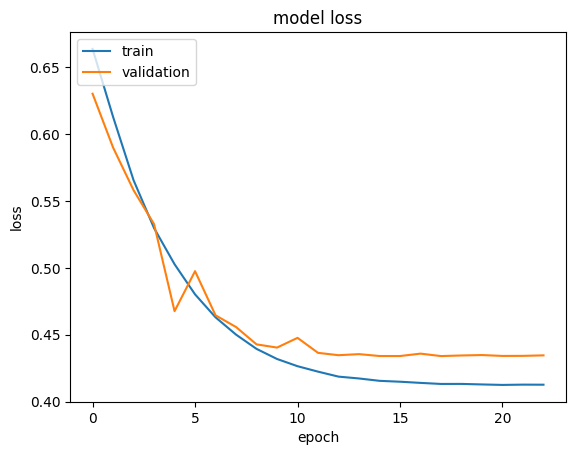

In [164]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [165]:
model.save('model.h5')

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [166]:
model.save('saved_model', save_format='tf')

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [167]:
place_df = tourist_attraction[['place_id','name','category','rating','latitude','longitude']]
df = user_rating.copy()

In [168]:
place_df

,place_id,name,category,rating,latitude,longitude
0,1,4 Brahma Statue Arts,Patung,4.3,-7.247284,112.801081
1,2,Adventure Land Romokalisari,Tujuan Wisata,4.6,-7.198610,112.664771
2,3,Alun - Alun Surabaya,Tujuan Wisata,4.8,-7.263864,112.745306
3,4,Apsari Park,Taman,4.6,-7.263635,112.742562
4,5,Arca Joko Dolog,Bangunan Bersejarah,4.6,-7.264916,112.742777
...,...,...,...,...,...,...
70,71,Taman Persahabatan,Taman bermain,4.6,-7.276744,112.745968
71,72,Taman Pertanian Terpadu Balas Klumprik,Taman,4.4,-7.329670,112.691251
72,73,Taman Prestasi Surabaya,Taman Kota,4.6,-7.261472,112.742828
73,74,Taman Teratai,Taman,4.4,-7.255100,112.755581


In [169]:
user_id = df.user_id.sample(1).iloc[0]
place_visited_by_user = df[df.user_id == user_id]

In [170]:
place_visited_by_user

,user_id,place_id,rating
49,20,1,5
50,20,24,5
51,20,28,5
52,20,45,4
53,20,54,5
54,20,56,5
55,20,57,5


In [171]:
place_not_visited = place_df[~place_df['place_id'].isin(place_visited_by_user.place_id.values)]['place_id']
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)

place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)
user_place_array = [user_place_array[:, 0], user_place_array[:, 1]]

In [172]:
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-5:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]

print('Daftar rekomendasi untuk: {}'.format('User ' + str(user_id)))
print('===' * 15,'\n')
print('----' * 15)
print('Tempat dengan rating wisata paling tinggi dari user')
print('----' * 15)

top_place_user = (
    place_visited_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .place_id.values
)

place_df_rows = place_df[place_df['place_id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.name, ':', row.category)

print('')
print('----' * 15)
print('Top 5 place recommendation')
print('----' * 15)

recommended_place = place_df[place_df['place_id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.name, '\n    ', row.category, ',', 'Rating Wisata ', row.rating,'\n')

print('==='*15)

3/3 [==============================] - 0s 8ms/step
Daftar rekomendasi untuk: User 20

------------------------------------------------------------
Tempat dengan rating wisata paling tinggi dari user
------------------------------------------------------------
4 Brahma Statue Arts : Patung
Kwan Im Goddess Statue : Tujuan Wisata
Monumen Bambu Runcing : Monumen
Suro and Boyo Statue : Tengara budaya
Suroboyo Park : Taman Kota

------------------------------------------------------------
Top 5 place recommendation
------------------------------------------------------------
1 . Kenjeran Park 
     Taman Ekologi , Rating Wisata  4.2 

2 . KidZania Surabaya 
     Taman Bermain Dalam Ruangan , Rating Wisata  4.8 

3 . Korean Friendship Park 
     Taman , Rating Wisata  4.5 

4 . Mangrove Wonorejo Ecotourism 
     Tujuan Wisata , Rating Wisata  4.3 

5 . Unesa Lake 
     Tujuan Wisata , Rating Wisata  4.5 



In [173]:
recommended_place

,place_id,name,category,rating,latitude,longitude
19,20,Kenjeran Park,Taman Ekologi,4.2,-7.252296,112.796695
20,21,KidZania Surabaya,Taman Bermain Dalam Ruangan,4.8,-7.290551,112.706422
21,22,Korean Friendship Park,Taman,4.5,-7.283063,112.736601
26,27,Mangrove Wonorejo Ecotourism,Tujuan Wisata,4.3,-7.308648,112.821662
74,75,Unesa Lake,Tujuan Wisata,4.5,-7.301489,112.674925


In [174]:
bus_route = pd.read_excel('bus_route_merged.xlsx')
bus_route

,nama,latitude,longitude
0,Terminal Purabaya (Bungurasih),-7.352082,112.724435
1,Halte Dukuh Menanggal,-7.343490,112.728930
2,Halte Kerto Menanggal,-7.343523,112.729403
3,Halte Siwalankerto,-7.337048,112.729054
4,Halte Taman Pelangi,-7.329158,112.730918
...,...,...,...
190,Samsat Tandes 1,-7.259950,112.688720
191,Samsat Tandes 2,-7.259741,112.688796
192,Margomulyo 2,-7.237190,112.682900
193,Margomulyo 1,-7.237180,112.682300


In [175]:
from geopy.distance import geodesic

def find_nearest_bus_route(place, bus_route):
    min_distance = float('inf')
    nearest_bus_route = None

    for _, bus_route in bus_route.iterrows():
        distance = geodesic((place['latitude'], place['longitude']),
                            (bus_route['latitude'], bus_route['longitude'])).kilometers

        if distance < min_distance:
            min_distance = distance
            nearest_bus_route = bus_route

    return nearest_bus_route, min_distance

In [176]:
result_rows = []

for _, place in recommended_place.iterrows():
    nearest_bus_stop, distance = find_nearest_bus_route(place, bus_route)
    result_rows.append({
        'place_name': place['name'],
        'place_latitude': place['latitude'],
        'place_longitude': place['longitude'],
        'nearest_bus_stop': nearest_bus_stop['nama'],
        'bus_stop_latitude': nearest_bus_stop['latitude'],
        'bus_stop_longitude': nearest_bus_stop['longitude'],
        'distance_to_nearest_bus_stop': distance
    })

result_df = pd.DataFrame(result_rows)

In [177]:
result_df

,place_name,place_latitude,place_longitude,nearest_bus_stop,bus_stop_latitude,bus_stop_longitude,distance_to_nearest_bus_stop
0,Kenjeran Park,-7.252296,112.796695,Halte Kenpark,-7.252737,112.796098,0.082000
1,KidZania Surabaya,-7.290551,112.706422,Halte Taman Makam Pahlawan 2,-7.288883,112.708450,0.290119
2,Korean Friendship Park,-7.283063,112.736601,Halte Darmo Gozco,-7.283447,112.740005,0.378382
3,Mangrove Wonorejo Ecotourism,-7.308648,112.821662,Halte PENS,-7.275230,112.801114,4.336788
4,Unesa Lake,-7.301489,112.674925,Halte Babatan 2 [notice],-7.298334,112.675358,0.352182


In [178]:
recommended_tourist_attraction = result_df[['place_name', 'place_latitude','place_longitude']]
recommended_tourist_attraction

,place_name,place_latitude,place_longitude
0,Kenjeran Park,-7.252296,112.796695
1,KidZania Surabaya,-7.290551,112.706422
2,Korean Friendship Park,-7.283063,112.736601
3,Mangrove Wonorejo Ecotourism,-7.308648,112.821662
4,Unesa Lake,-7.301489,112.674925


In [179]:
recommended_bus_route = result_df[['nearest_bus_stop', 'bus_stop_latitude', 'bus_stop_longitude']]
recommended_bus_route

,nearest_bus_stop,bus_stop_latitude,bus_stop_longitude
0,Halte Kenpark,-7.252737,112.796098
1,Halte Taman Makam Pahlawan 2,-7.288883,112.708450
2,Halte Darmo Gozco,-7.283447,112.740005
3,Halte PENS,-7.275230,112.801114
4,Halte Babatan 2 [notice],-7.298334,112.675358
